# **CNN on CIFAR-10 dataset**

In this notebook we will define and train a CNN architecture from scratch on CIFAR-10 dataset.

CIFAR-10 dataset contains 32x32 color images from 10 classes: __airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__:
<img src="images/cifar10.jpg" style="width:80%">

As the image size is 32x32, the image quality is not obviosly very good. But, let's see if we can workout with these images to get a respectable model accuracy.

### **Import required libraries**

In [ ]:
import sys
sys.path.append("..")
import grading
import download_utils

In [ ]:
download_utils.link_all_keras_resources()

In [ ]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np

print(tf.__version__)
print(keras.__version__)

Using TensorFlow backend.


1.2.1
2.0.6


In [ ]:
import grading_utils
import keras_utils
from keras_utils import reset_tf_session

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

### **Load dataset from `keras.datasets`**

In [ ]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


So the dataset contains 50000 images in the training set, and 10000 images in the testing set.

The number of output labels are 10, means 10 classes.

In [ ]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

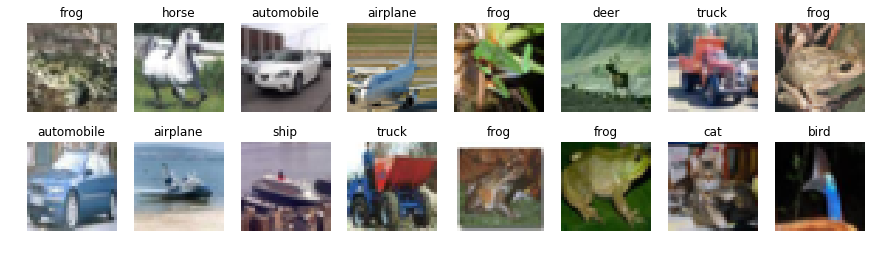

In [ ]:
# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

### **Data Preprocessing**

We need to normalize inputs like this: $$x_{norm} = \frac{x}{255} - 0.5$$

Subtracting 0.5 from inputs will make the distribution mean as 0.

We also need to convert class labels into one-hot encoded vectors. We can use __keras.utils.to_categorical__.

In [ ]:
# normalize inputs
x_train2 = x_train / 255.0 - 0.5
x_test2 = x_test / 255.0 - 0.5

# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, NUM_CLASSES)

## **Define CNN architecture**

In [ ]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, InputLayer
from keras.layers.advanced_activations import LeakyReLU

Convolutional networks are built from several types of layers:
- `Conv2D` - performs convolution:
    - **filters**: number of output channels; 
    - **kernel_size**: an integer or tuple/list of 2 integers, specifying the width and height of the 2D convolution window;
    - **padding**: padding="same" adds zero padding to the input, so that the output has the same width and height, padding='valid' performs convolution only in locations where kernel and the input fully overlap;
    - **activation**: "relu", "tanh", etc.
    - **input_shape**: shape of input.
- `MaxPooling2D` - performs 2D max pooling.
- `Flatten` - flattens the input, does not affect the batch size.
- `Dense` - fully-connected layer.
- `Activation` - applies an activation function.
- `LeakyReLU` - applies leaky relu activation.
- `Dropout` - applies dropout.

In [ ]:
def make_model():
    """
    Returns `Sequential` model.
    """
    model = Sequential()
    model.add(Conv2D(16, [3, 3], padding='same', input_shape=(32, 32, 3)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, [3, 3], padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D([2, 2]))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(32, [3, 3], padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64, [3, 3], padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D([2, 2]))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, ))
    model.add(Dropout(0.5))
    model.add(LeakyReLU(0.1))
    
    model.add(Dense(10, ))
    model.add(Activation('softmax'))
    
    return model

In [ ]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
__________

### **Model training**

In [ ]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

s = reset_tf_session()  # clear default graph
  
# define our model
model = make_model()

# model loss and optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adamax(lr=INIT_LR),
    metrics=['accuracy']
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

As the training will take a long time, we will continuously save model checkpoints so that we can resume our training from the last checkpoint rather than restarting from zero. This is essentially helpful when we use online resources like Google Colab, or Microsoft Azure notebooks, etc.

In [ ]:
# we will save model checkpoints to continue training in case of kernel death
model_filename = 'cifar.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 7
# model = load_model(model_filename.format(last_finished_epoch))

In [ ]:
# fit model
model.fit(
    x_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(), 
               keras_utils.TqdmProgressCallback(),
               keras_utils.ModelSaveCallback(model_filename)],
    validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)

Learning rate: 0.005

Epoch 1/10


A Jupyter Widget

50000/|/loss: 0.8364; acc: 0.7060: 100%|| 50000/50000 [08:31<00:00, 94.43it/s]
Model saved in cifar.000.hdf5
Learning rate: 0.0045

Epoch 2/10


A Jupyter Widget

50000/|/loss: 0.7476; acc: 0.7358: 100%|| 50000/50000 [08:41<00:00, 93.55it/s]
Model saved in cifar.001.hdf5
Learning rate: 0.00405

Epoch 3/10


A Jupyter Widget

50000/|/loss: 0.6861; acc: 0.7599: 100%|| 50000/50000 [08:41<00:00, 93.76it/s]
Model saved in cifar.002.hdf5
Learning rate: 0.003645

Epoch 4/10


A Jupyter Widget

50000/|/loss: 0.6222; acc: 0.7832: 100%|| 50000/50000 [08:41<00:00, 103.40it/s]
Model saved in cifar.003.hdf5
Learning rate: 0.0032805

Epoch 5/10


A Jupyter Widget

50000/|/loss: 0.5869; acc: 0.7943: 100%|| 50000/50000 [08:41<00:00, 90.88it/s]
Model saved in cifar.004.hdf5
Learning rate: 0.00295245

Epoch 6/10


A Jupyter Widget

50000/|/loss: 0.5481; acc: 0.8081: 100%|| 50000/50000 [08:41<00:00, 92.72it/s]
Model saved in cifar.005.hdf5
Learning rate: 0.00265721

Epoch 7/10


A Jupyter Widget

50000/|/loss: 0.5120; acc: 0.8199: 100%|| 50000/50000 [08:41<00:00, 93.97it/s]
Model saved in cifar.006.hdf5
Learning rate: 0.00239148

Epoch 8/10


A Jupyter Widget

50000/|/loss: 0.4866; acc: 0.8288: 100%|| 50000/50000 [08:41<00:00, 91.60it/s]
Model saved in cifar.007.hdf5
Learning rate: 0.00215234

Epoch 9/10


A Jupyter Widget

50000/|/loss: 0.4648; acc: 0.8374: 100%|| 50000/50000 [08:51<00:00, 93.46it/s]

In [ ]:
# save weights to file
model.save_weights("weights.h5")

In [ ]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

### **Model evaluation**

In [ ]:
# making test predictions
y_pred_test = model.predict_proba(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

 9984/10000 [============================>.] - ETA: 0s

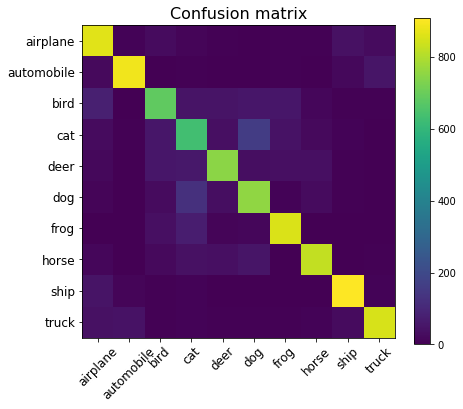

Test accuracy: 0.8026


In [ ]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

In [ ]:
# inspecting predictions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()